In [112]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import warnings
import math
from scipy.optimize import curve_fit
from collections import deque, defaultdict
from itertools import combinations
import seaborn as sns
from scipy import stats
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [113]:
def connectivityExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    connectivity_raw = data_structure['connectivity'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    connectivity_data = connectivity_raw.squeeze()
    # Create a DataFrame from the connectivity data
    connectivity_df = pd.DataFrame(connectivity_data, columns=['Parent', 'Daughter1', 'Daughter2', 'Daughter3'])
    connectivity_df.replace(0, np.nan, inplace=True) #ensure all nonexistent vessels have NaN
    connectivity_df.at[0,'Parent']=0 #make sure first vessel is 0 (purposefully removed in last step for ease)
    # Save the DataFrame to inspect it
    return connectivity_df

def lengthExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'lengths' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    length_raw = data_structure['lengths'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    length_data = length_raw.squeeze()
    # Create a DataFrame from the data
    length_df = pd.DataFrame(length_data, columns=['Length'])
    # Save the DataFrame to inspect it
    return length_df

def radiusExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'radius' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    radius_raw = data_structure['rin'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    radius_data = radius_raw.squeeze()
    # Create a DataFrame from the data
    radius_df = pd.DataFrame(radius_data, columns=['Radius'])
    # Save the DataFrame to inspect it
    return radius_df

def volumeExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name + '.mat'
    matlab_data = scipy.io.loadmat(file_path)
    volume_raw = matlab_data['volumes']  # This is an x by 1 or 1D array
    volume_data = volume_raw.squeeze()  # Converts to 1D array if it's still 2D with 1 column
    volume_df = pd.DataFrame(volume_data, columns=['Volume'])
    return volume_df

def lRR(data):
    lrr = np.empty((0,0))
    for i in np.arange(data.shape[0]): #iterate over every vessel
        length = data.iloc[i]['Length'] #pull the length value
        radius = data.iloc[i]['Radius'] #retreive radius value
        lrr_value = length/radius #calculate lrr
        lrr = np.append(lrr,lrr_value) #append lrr value to total list
    data['Length/Radius'] = lrr.tolist() #add list to table
    return data

def assignDepth(data):
    tree = {} 
    for _, row in data.iterrows(): #iterate over every row
        parent = row['Parent']
        daughters = row[['Daughter1', 'Daughter2', 'Daughter3']].dropna().astype(int).tolist() #only select daughter values that exist
        tree[parent] = daughters
    # Step 2: BFS traversal to assign depths
    depths = {}
    queue = deque([(data['Parent'].iloc[0], 0)])  # Start from root (first parent)

    while queue:
        node, depth = queue.popleft()
        depths[node] = depth
        for child in tree.get(node, []):
            if child not in depths:  # Avoid revisiting
                queue.append((child, depth + 1))
    data['Depth'] = data['Parent'].map(depths)
    return data

def lengthFromRoot(data):
    tree = {}
    length_dict = dict(zip(data['Parent'], data['Length']))  # Map each vessel (parent) to its length

    for _, row in data.iterrows():
        parent = row['Parent']
        daughters = row[['Daughter1', 'Daughter2', 'Daughter3']].dropna().astype(int).tolist()
        tree[parent] = daughters

    # BFS traversal to calculate cumulative lengths
    lengths = {}
    root = data['Parent'].iloc[0]
    queue = deque([(root, 0)])  # Start with cumulative length 0

    while queue:
        node, cum_length = queue.popleft()
        lengths[node] = cum_length
        for child in tree.get(node, []):
            if child not in lengths:  # Avoid revisiting
                additional_length = length_dict.get(child, 0)
                queue.append((child, cum_length + additional_length))

    data['LengthFromRoot'] = data['Parent'].map(lengths)
    return data

def nodesExtractor(name): #extracts nodes and their corresponding information
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'nodes' field
    data_structure = matlab_data['nodesC2']
    # Reshape or ensure it's a proper 2D array (if required)
    nodes_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    nodes_df = pd.DataFrame(nodes_data, columns=['NodeID', 'X', 'Y', 'Z', 'Degree'])
    # Save the DataFrame to inspect it
    return nodes_df

def edgesExtractor(name): #extracts segments to create a dataframe of from and to nodes
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'segments' field
    data_structure = matlab_data['segments']
    # Reshape or ensure it's a proper 2D array (if required)
    edges_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    edge_df = pd.DataFrame(edges_data, columns=['Old', 'From', 'To'])
    # Save the DataFrame to inspect it
    return edge_df

def mapIDExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'mapID' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    map_raw = data_structure['mapIDs'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    map_data = map_raw.squeeze()
    # Create a DataFrame from the connectivity data
    map_df = pd.DataFrame(map_data, columns=['New', 'Old'])
    # Save the DataFrame to inspect it
    return map_df

def tortuosityCalculator(data,name):
    nodes = nodesExtractor(name)
    edges = edgesExtractor(name)
    maps = mapIDExtractor(name)
    tortuosity = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        old_vesID = maps.iloc[i]['Old'] #find the old vessel ID
        edge_row = edges.index.get_loc(edges[edges['Old'] == old_vesID].index[0])
        node1 = edges.iloc[edge_row]['From'] #identify from node
        node2 = edges.iloc[edge_row]['To'] #identify to node
        node1_row = nodes.index.get_loc(nodes[nodes['NodeID'] == node1].index[0])
        node2_row = nodes.index.get_loc(nodes[nodes['NodeID'] == node2].index[0])
        node1_x = nodes.iloc[node1_row]['X'] #pull node 3d coordinate
        node1_y = nodes.iloc[node1_row]['Y']
        node1_z = nodes.iloc[node1_row]['Z']
        node2_x = nodes.iloc[node2_row]['X']
        node2_y = nodes.iloc[node2_row]['Y']
        node2_z = nodes.iloc[node2_row]['Z']
        euclid_dist = math.sqrt((node1_x - node2_x)**2 + (node1_y - node2_y)**2 + (node1_z - node2_z)**2) #calculate euclidean distance between from and to
        length = data.iloc[i]['Length'] #pull length and convert to mm
        ratio = length/euclid_dist #find tortuosity ratio
        tortuosity = np.append(tortuosity,ratio)
    data['Tortuosity'] = tortuosity.tolist() #add to table
    return data

def radiusFinder(data):
    dv1r = np.empty((0,0))
    dv2r = np.empty((0,0))
    dv3r = np.empty((0,0))
    for i in np.arange(data.shape[0]):# iterate over every row
        dv1 = data.iloc[i]['Daughter1'] #pull radii values
        dv2 = data.iloc[i]['Daughter2']
        dv3 = data.iloc[i]['Daughter3']
        if math.isnan(dv1): #if daughter vessel 1 doesn't exist, none of them do
            dv1r = np.append(dv1r,np.nan)
            dv2r = np.append(dv2r,np.nan)
            dv3r = np.append(dv3r,np.nan)
            continue
        dv1r = np.append(dv1r,data.iloc[int(dv1)][2])
        dv2r = np.append(dv2r,data.iloc[int(dv2)][2])
        if math.isnan(dv3): #explicitly check whetehr dv3 exist
            dv3r = np.append(dv3r,np.nan)
            continue
        dv3r = np.append(dv3r,data.iloc[int(dv3)][2])
    data['DV1R'] = dv1r.tolist()
    data['DV2R'] = dv2r.tolist()
    data['DV3R'] = dv3r.tolist()
    #select and reorder columns
    data = data.loc[:,['Parent','Depth','Length','Radius','Volume', 'Length/Radius','LengthFromRoot','Tortuosity','Daughter1','DV1R','Daughter2','DV2R','Daughter3','DV3R']]
    return data

def alphaBeta(data):
    alpha = np.empty((0,0))
    beta = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        if not math.isnan(data.iloc[i]['DV3R']): #check if trifurcation, if it is then don't calculate
            alpha = np.append(alpha,np.nan)
            beta = np.append(beta,np.nan)
            continue
        dv1r = data.iloc[i]['DV1R']
        dv2r = data.iloc[i]['DV2R']
        pv = data.iloc[i]['Radius']
        if math.isnan(dv1r): #check if daughter vessels exist
            alpha = np.append(alpha,np.nan)
            beta = np.append(beta,np.nan)
            continue
        if dv1r>=dv2r: #case 1 of daughter vessels
            alpha_value = dv1r/pv
            beta_value = dv2r/pv
        else: #case 2 of daughter vessels
            alpha_value = dv2r/pv
            beta_value = dv1r/pv
        alpha = np.append(alpha,alpha_value)
        beta = np.append(beta,beta_value)
    data['Alpha'] = alpha.tolist() #add alpha and beta to total table
    data['Beta'] = beta.tolist()
    return data

def xiFinder(data):
    xi_values = np.empty((0,0))
    error_values = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        rp = data.iloc[i]['Radius']/1000 #pull all radii and convert to mm
        rd1 = data.iloc[i]['DV1R']/1000
        rd2 = data.iloc[i]['DV2R']/1000
        rd3 = data.iloc[i]['DV3R']/1000
        if not math.isnan(rd3): #don't calculate if trifucation
            xi_values = np.append(xi_values,np.nan)
            error_values = np.append(error_values,np.nan)
            continue
        if math.isnan(rd1): #don't calculate if no daughter vessels
            xi_values = np.append(xi_values,np.nan)
            error_values = np.append(error_values,np.nan)
            continue
        xi = 2.5
        error = rp**xi - rd1**xi - rd2**xi
        while abs(error) > 1e-3: #allow for error up to 10^-4
            fun = rp**xi - rd1**xi - rd2**xi # solve at f(xi)
            fun2 = (rp**xi)*math.log(rp) - (rd1**xi)*math.log(rd1) - (rd2**xi)*math.log(rd2) #solve at f'(xi)
            xi = xi - fun/fun2 # new xi value
            error = rp**xi - rd1**xi - rd2**xi #calculate new error
        if xi > 4: #bound xi
            xi = 4
        if xi < 2:
            xi = 2
        error = rp**xi - rd1**xi - rd2**xi
        xi_values = np.append(xi_values,xi)
        error_values = np.append(error_values,error)
    data['Xi'] = xi_values.tolist()#add xi to the table
    #data['Error Newton'] = error_values.tolist()
    return data

def asymmetry(data):
    asym = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        if not math.isnan(data.iloc[i]['DV3R']): #don't calculate if trifucation
            asym = np.append(asym,np.nan)
            continue
        dv1r = data.iloc[i]['DV1R'] #pull radii
        dv2r = data.iloc[i]['DV2R']
        if math.isnan(dv1r): #if no daughters, skip
            asym = np.append(asym,np.nan)
            continue
        if dv1r>=dv2r: #case 1
            asym_value = (dv2r/dv1r)**2
        else: #case 2
            asym_value = (dv1r/dv2r)**2
        asym = np.append(asym,asym_value)
    data['Gamma'] = asym.tolist() #add to table
    return data

def area(data):
    area = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        if not math.isnan(data.iloc[i]['DV3R']): #if trifucation, skip
            area = np.append(area,np.nan)
            continue
        dv1r = data.iloc[i]['DV1R'] #pull necessary radii
        dv2r = data.iloc[i]['DV2R']
        pv = data.iloc[i]['Radius']
        if math.isnan(dv1r): #if no daughters, skip
            area = np.append(area,np.nan)
            continue
        area_value = (dv1r**2+dv2r**2)/(pv**2) #calculate eta
        area = np.append(area,area_value)
    data['Eta'] = area.tolist() #add to table
    return data

def angleExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    angles = matlab_data['Angles']
    headers = [str(h.item()) if isinstance(h,np.ndarray) else str(h) for h in angles[0]]
    columns = [angles[1,i].squeeze() for i in range(len(headers))]
    angled = pd.DataFrame(dict(zip(headers,columns)))
    return angled

def matchAngles(data,name):
    angles = angleExtractor(name)
    edges = edgesExtractor(name)
    maps = mapIDExtractor(name)
    newOldIDs = pd.merge(maps, edges, on='Old', how='left')
    angleID = pd.merge(newOldIDs,angles,left_on='To',right_on='hubNode')
    angleID.drop(['Old','From','To','hubNode'],axis=1,inplace=True)
    #vesAngle = angleID.merge(data,left_on='New',right_on='Parent',how='left')
    angled = data.merge(angleID,left_on='Parent',right_on='New',how='left')
    angled = angled.drop(columns='New')
    return angled

def offPrincipalPath(data):
    # Initialize BFS queue and results
    queue = deque([0])  # Start with the first row
    visited = set()
    principal_path = []
    
    # Get the initial radius
    root_radius = data.loc[0, 'Radius']
    
    while queue:
        current = queue.popleft()
        if current in visited:
            continue
        visited.add(current)
        principal_path.append(current)
        
        # Parent radius
        parent_radius = data.loc[current, 'Radius']
        
        # Check each daughter
        for i in range(1, 4):
            daughter_col = f'Daughter{i}'
            dvr_col = f'DV{i}R'
            if daughter_col in data.columns and dvr_col in data.columns:
                daughter = data.loc[current, daughter_col]
                dvr = data.loc[current, dvr_col]
                if not pd.isna(daughter) and not pd.isna(dvr):
                    if dvr >= 0.4 * root_radius:
                        queue.append(int(daughter))
    
    # Create a copy of the data
    result_df = data.copy()
    
    # Set specified columns to NaN for vessels on the principal pathway
    columns_to_nan = ['Alpha', 'Beta', 'Gamma', 'Eta', 'Xi']
    result_df.loc[result_df['Parent'].isin(principal_path), columns_to_nan] = np.nan
    
    return result_df

def dataExtractor(name): #sequentially calls necessary functions to create full table
    connectivity = connectivityExtractor(name)
    length = lengthExtractor(name)
    radius = radiusExtractor(name)
    volume = volumeExtractor(name)
    combined = pd.concat([connectivity.iloc[:, :1], length, radius, volume, connectivity.iloc[:, 1:]], axis=1)
    lengthradius = lRR(combined)
    #print('LRR')
    depthness = assignDepth(lengthradius)
    #print('Depth')
    lengthTotal = lengthFromRoot(depthness)
    #print('LengthFromRoot')
    tortuos = tortuosityCalculator(lengthTotal,name)
    #print('Tortousity')
    allradii = radiusFinder(tortuos)
    angled = matchAngles(allradii,name)
    alphabetazed = alphaBeta(angled)
    #print('Alpha/beta')
    xi = xiFinder(alphabetazed)
    #print('Xi')
    asymmetric = asymmetry(xi)
    #print('Gamma')
    areated = area(asymmetric)
    opp = offPrincipalPath(areated)
    return opp

def saveStatistics(name): #saves the stats as .csv for exporting
    statistics = dataExtractor(name)
    file_path = 'Statistics/Statistics_' + name +'.csv'
    statistics.to_csv(file_path) #shouldn't return anything, just save

def leaveDetails(statistics,name):
    #statistics = dataExtractor(name)
    dropped = statistics.dropna(subset='DV1R')
    internal = dropped.shape[0]
    tris = dropped['DV3R'].count()
    leaves = statistics['DV1R'].isna().sum()
    triratio = tris/internal * 100
    avgdepth = statistics[statistics['Daughter1'].isna()]['Depth'].mean()
    stddepth = statistics[statistics['Daughter1'].isna()]['Depth'].std()
    volume = statistics['Volume'].sum()/(1000**3)
    print(name)
    print('# of vessels: ' + str(statistics.shape[0]))
    print('# of leaves (terminal vessels): ' + str(leaves))
    print('# of internal vessels: ' + str(internal))
    print('# of trifurcations: '+ str(tris))
    print('% of trifurcations: ' + str(round(triratio,3)))
    print('Volume (mm^3): ' + str(round(volume,3)))
    print('Average Depth of terminal vessel: ' + str(round(avgdepth,3)))
    print('St. Dev. Depth of terminal vessel: ' + str(round(stddepth,3)))


# Data Extraction

In [114]:
hyper1 = dataExtractor('m1p1_060107')
hyper1.head(10)

,Parent,Depth,Length,Radius,Volume,Length/Radius,LengthFromRoot,Tortuosity,Daughter1,DV1R,Daughter2,DV2R,Daughter3,DV3R,psi_1,psi_2,theta_1,theta_2,Alpha,Beta,Xi,Gamma,Eta
0,0.0,0,5211.478491,432.196534,3.086755e+09,12.058122,0.000000,1.264460,1260.0,436.272229,1262.0,320.065936,NaN,NaN,0.39383,0.761534,1.095179,-2.755315,NaN,NaN,NaN,NaN,NaN
1,1.0,11,448.445123,65.685146,5.862506e+06,6.827192,8955.073282,1.341272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,8,531.173592,78.210801,1.387427e+07,6.791563,7704.597101,1.228104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,12,694.247711,90.697160,2.327095e+07,7.654569,15955.189163,1.237316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,18,681.449572,68.512983,1.112527e+07,9.946284,14645.143499,1.547497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5.0,16,774.755746,66.889007,1.182901e+07,11.582707,14770.637845,1.167594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6.0,7,380.897611,97.697238,1.260583e+07,3.898755,10916.223314,1.245438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7.0,16,879.488856,72.246688,1.755486e+07,12.173414,18204.046132,1.166907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8.0,12,313.350100,73.190249,5.564973e+06,4.281309,12211.377744,1.142033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9.0,17,1092.709097,82.917189,2.671073e+07,13.178318,18870.680299,1.307825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pressure = '1'
datasets = {
    'm1053007': 'm1p'+pressure+'_053007',
    'm2053007': 'm2p'+pressure+'_053007',
    'm1053107': 'm1p'+pressure+'_053107',
    'm2053107': 'm2p'+pressure+'_053107',
    'm1060107': 'm1p'+pressure+'_060107',
    'm1060407': 'm1p'+pressure+'_060407',
    'm2060407': 'm2p'+pressure+'_060407',
    'm3060407': 'm3p'+pressure+'_060407',
    'm1060507': 'm1p'+pressure+'_060507',
    'm2060507': 'm2p'+pressure+'_060507',
    'm3060507': 'm3p'+pressure+'_060507',
    'm2060607': 'm2p'+pressure+'_060607',
    'm3060607': 'm3p'+pressure+'_060607',
}

for key in datasets:
    saveStatistics(datasets[key])

: 

In [3]:
#Control Mice
control1 = dataExtractor('m1p4_060407')
control2 = dataExtractor('m2p4_060407')
control3 = dataExtractor('m3p4_060407')
control4 = dataExtractor('m1p4_060507')
control5 = dataExtractor('m2p4_060507')
control6 = dataExtractor('m3p4_060507')
control7 = dataExtractor('m2p4_060607')
control8 = dataExtractor('m3p4_060607')

In [4]:
# Hypertensive Mice
hyper1 = dataExtractor('m1p4_053007')
hyper2 = dataExtractor('m2p4_053007')
hyper3 = dataExtractor('m1p4_053107')
hyper4 = dataExtractor('m2p4_053107')
hyper5 = dataExtractor('m1p4_060107')

In [103]:
control1.head(1)

,Parent,Depth,Length,Radius,Volume,Length/Radius,LengthFromRoot,Tortuosity,Daughter1,DV1R,Daughter2,DV2R,Daughter3,DV3R,psi_1,psi_2,theta_1,theta_2,Alpha,Beta,Xi,Gamma,Eta
0,0.0,0,3611.621587,386.586304,1.804240e+09,9.342342,0.0,1.274013,590.0,359.569204,601.0,242.339684,NaN,NaN,0.705166,0.502965,-0.217215,2.992375,0.930114,0.626871,3.192642,0.454239,1.258078


# Off Principal Pathway Comparisons

In [104]:
def lobeExtractor(name, vesID):
    data = dataExtractor(name)
    
    tree = defaultdict(list)
    for _,row in data.iterrows():
        parent = row['Parent']
        for daughter_col in ['Daughter1','Daughter2','Daughter3']:
            daughter = row[daughter_col]
            if pd.notna(daughter):
                tree[parent].append(daughter)

    visited = set()
    queue = deque([vesID])

    while queue:
        current = queue.popleft()
        if current not in visited:
            visited.add(current)
            queue.extend(tree.get(current,[]))
    
    downstream_df = data[data['Parent'].isin(visited) | data['Parent'].isin([vesID])]
    return downstream_df.reset_index()


def lobeInput(name,fromnode,tonode):
    segments = edgesExtractor(name)
    maps = mapIDExtractor(name)
    newOldIDs = pd.merge(maps, segments, on='Old', how='left')
    newVesID = int(newOldIDs[((newOldIDs['From'] == fromnode)&(newOldIDs['To']==tonode))].iloc[0,0])
    lobe = lobeExtractor(name,newVesID)
    return lobe

def offPrincipalPath(data):
    # Initialize BFS queue and results
    queue = deque([0])  # Start with the first row
    visited = set()
    principal_path = []

    # Get the initial radius
    root_radius = data.loc[0, 'Radius']

    while queue:
        current = queue.popleft()
        if current in visited:
            continue
        visited.add(current)
        principal_path.append(current)

        # Parent radius
        parent_radius = data.loc[current, 'Radius']

        # Check each daughter
        for i in range(1, 4):
            daughter_col = f'Daughter{i}'
            dvr_col = f'DV{i}R'

            if daughter_col in data.columns and dvr_col in data.columns:
                daughter = data.loc[current, daughter_col]
                dvr = data.loc[current, dvr_col]

                if not pd.isna(daughter) and not pd.isna(dvr):
                    if dvr >= 0.4 * root_radius:
                        queue.append(int(daughter))
    off_path_df = data[~data['Parent'].isin(principal_path)].copy()
    # Now filter for Radius > 0.2 * root_radius
    #off_path_df = off_path_df[off_path_df['Radius'] > 0.2 * root_radius].copy()
    return off_path_df

def saveStatisticsOPP(name): #saves the stats as .csv for exporting
    statistics = dataExtractor(name)[["Parent", "Depth",'Length','Radius','Volume','Length/Radius','LengthFromRoot','Tortuosity','Alpha','Beta','Xi','Gamma','Eta']] #selects correct columns
    statsOPP = offPrincipalPathway(statistics)
    file_path = 'Statistics/Statistics_' + name +'.csv'
    statsOPP.to_csv(file_path) #shouldn't return anything, just save
    

def bintoPlot(data,y,x):
    filtered = offPrincipalPath(data)
    filtered = filtered.dropna(subset=[x, y])
    labels = np.arange(20)
    filtered['binned'] = pd.qcut(filtered[x].rank(method='first'), 20,labels = labels)
    a = filtered.groupby('binned')[x].mean()
    b = filtered.groupby('binned')[y].mean()
    return a,b

def exponential(x, a, b):
    return a * np.exp(-b * x)
    #return a*(x**-b)

def percOPP(data):
    opp = offPrincipalPath(data)
    print(opp.shape[0])
    percent = opp.shape[0]/data.shape[0]*100
    return percent

In [105]:
left_lobe = lobeInput('m1p4_060107',215,1664)
opp = offPrincipalPath(hyper1)
print(left_lobe[left_lobe['Parent'].isin(opp['Parent'])].shape[0])
print(left_lobe['Volume'].sum()/(1000**3))

387
11.243511185515034


In [106]:
# Bin Controls
y = 'Radius'
x = 'Radius'
c1x,c1y = bintoPlot(control1,y,x)
c2x,c2y = bintoPlot(control2,y,x)
c3x,c3y = bintoPlot(control3,y,x)
c4x,c4y = bintoPlot(control4,y,x)
c5x,c5y = bintoPlot(control5,y,x)
c6x,c6y = bintoPlot(control6,y,x)
c7x,c7y = bintoPlot(control7,y,x)
c8x,c8y = bintoPlot(control8,y,x)

In [107]:
# Bin Hypertensives
h1x,h1y = bintoPlot(hyper1,y,x)
h2x,h2y = bintoPlot(hyper2,y,x)
h3x,h3y = bintoPlot(hyper3,y,x)
h4x,h4y = bintoPlot(hyper4,y,x)
h5x,h5y = bintoPlot(hyper5,y,x)

In [108]:
control = np.concat((c1y,c2y,c3y,c4y,c5y,c6y,c7y,c8y),axis=0)
conavg = np.mean(control)
hyper = np.concat((h1y,h2y,h3y,h4y,h5y),axis=0)
hypavg = np.mean(hyper)
print(conavg)
print(hypavg)

84.7422289424816
81.4090715924805


Text(0.5, 1.0, 'Radius')

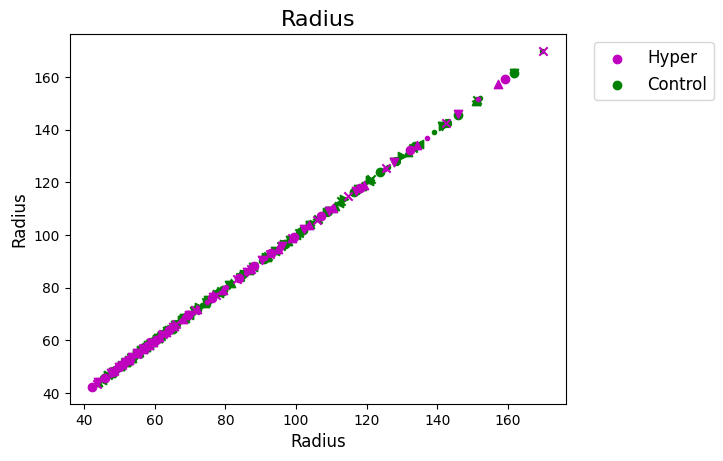

In [109]:
plt.scatter(c1x,c1y, c='g', marker='x')
plt.scatter(c2x,c2y, c='g', marker='.')
plt.scatter(c3x,c3y, c='g', marker='o')
plt.scatter(c4x,c4y, c='g', marker='v')
plt.scatter(c5x,c5y, c='g', marker='^')
plt.scatter(c6x,c6y, c='g', marker='<')
plt.scatter(c7x,c7y, c='g', marker='>')
plt.scatter(c8x,c8y, c='g', marker='8')
plt.scatter(h1x,h1y, c='m', marker='x')
plt.scatter(h2x,h2y, c='m', marker='.')
plt.scatter(h3x,h3y, c='m', marker='o')
plt.scatter(h4x,h4y, c='m', marker='v')
plt.scatter(h5x,h5y, c='m', marker='^')
plt.scatter([],[],c='m',label='Hyper')
plt.scatter([],[],c='g',label='Control')
#plt.hlines(y=[hypavg,conavg],xmin=70,xmax=200,colors=['m','g'],linestyles=['--','--'])
#plt.ylabel('Ratio')
plt.ylabel(y,fontsize=12)
plt.xlabel(x,fontsize=12)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left',fontsize=12)
plt.title(y,fontsize=16)

Text(0, 0.5, 'Count')

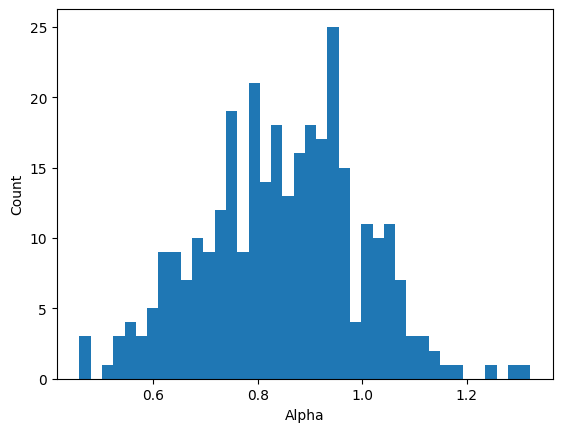

In [ ]:
plt.hist(control1[y].dropna(),bins=40)
plt.xlabel(y)
plt.ylabel('Count')

## Alpha and Beta Graphs

In [ ]:
# Bin Controls
y = 'Beta'
x = 'Radius'
c1x,c1y = bintoPlot(control1,y,x)
c2x,c2y = bintoPlot(control2,y,x)
c3x,c3y = bintoPlot(control3,y,x)
c4x,c4y = bintoPlot(control4,y,x)
c5x,c5y = bintoPlot(control5,y,x)
c6x,c6y = bintoPlot(control6,y,x)
c7x,c7y = bintoPlot(control7,y,x)
c8x,c8y = bintoPlot(control8,y,x)

In [26]:
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

In [27]:
# Bin Hypertensives
h1x,h1y = bintoPlot(hyper1,y,x)
h2x,h2y = bintoPlot(hyper2,y,x)
h3x,h3y = bintoPlot(hyper3,y,x)
h4x,h4y = bintoPlot(hyper4,y,x)
h5x,h5y = bintoPlot(hyper5,y,x)

In [28]:
controly = np.concat((c1y,c2y,c3y,c4y,c5y,c6y,c7y,c8y),axis=0)
controlx = np.concat((c1x,c2x,c3x,c4x,c5x,c6x,c7x,c8x),axis=0)
hypery = np.concat((h1y,h2y,h3y,h4y,h5y),axis=0)
hyperx = np.concat((h1x,h2x,h3x,h4x,h5x),axis=0)
# Fit for control data
p0 = [max(controly), np.median(controlx), 1, min(controly)]
sig_control, _ = curve_fit(sigmoid, controlx, controly, p0)
# Fit for hyper data
p0 = [max(hypery), np.median(hyperx), 1, min(hypery)]
sig_hyper, _ = curve_fit(sigmoid, hyperx, hypery, p0)

x_fit_control = np.linspace(min(controlx), max(controlx), 1000)
y_fit_control = sigmoid(x_fit_control, *sig_control)

x_fit_hyper = np.linspace(min(hyperx), max(hyperx), 1000)
y_fit_hyper = sigmoid(x_fit_hyper, *sig_hyper)

In [29]:
print(sig_control)
print(sig_hyper)

[-0.40405002 64.60665653  0.08215404  0.98598471]
[-1.47187214e+02 -7.15179600e+01  4.94763389e-02  1.47763607e+02]


In [30]:
# Bin Controls
y = 'Alpha'
x = 'Radius'
c1xa,c1ya = bintoPlot(control1,y,x)
c2xa,c2ya = bintoPlot(control2,y,x)
c3xa,c3ya = bintoPlot(control3,y,x)
c4xa,c4ya = bintoPlot(control4,y,x)
c5xa,c5ya = bintoPlot(control5,y,x)
c6xa,c6ya = bintoPlot(control6,y,x)
c7xa,c7ya = bintoPlot(control7,y,x)
c8xa,c8ya = bintoPlot(control8,y,x)

In [31]:
# Bin Hypertensives
h1xa,h1ya = bintoPlot(hyper1,y,x)
h2xa,h2ya = bintoPlot(hyper2,y,x)
h3xa,h3ya = bintoPlot(hyper3,y,x)
h4xa,h4ya = bintoPlot(hyper4,y,x)
h5xa,h5ya = bintoPlot(hyper5,y,x)

In [32]:
controlya = np.concat((c1ya,c2ya,c3ya,c4ya,c5ya,c6ya,c7ya,c8ya),axis=0)
controlxa = np.concat((c1xa,c2xa,c3xa,c4xa,c5xa,c6xa,c7xa,c8xa),axis=0)
hyperya = np.concat((h1ya,h2ya,h3ya,h4ya,h5ya),axis=0)
hyperxa = np.concat((h1xa,h2xa,h3xa,h4xa,h5xa),axis=0)
# Fit for control data
p0 = [max(controlya), np.median(controlxa), 1, min(controlya)]
sig_controla, _ = curve_fit(sigmoid, controlxa, controlya, p0)
# Fit for hyper data
p0 = [max(hyperya), np.median(hyperxa), 1, min(hyperya)]
sig_hypera, _ = curve_fit(sigmoid, hyperxa, hyperya, p0)

x_fit_controla = np.linspace(min(controlxa), max(controlxa), 1000)
y_fit_controla = sigmoid(x_fit_controla, *sig_controla)

x_fit_hypera = np.linspace(min(hyperxa), max(hyperxa), 1000)
y_fit_hypera = sigmoid(x_fit_hypera, *sig_hypera)

In [33]:
print(sig_controla)
print(sig_hypera)

[9.96074139e-02 1.11207042e+02 1.74172944e-01 7.92398376e-01]
[  0.11613617 105.50019438   0.15972763   0.78328499]


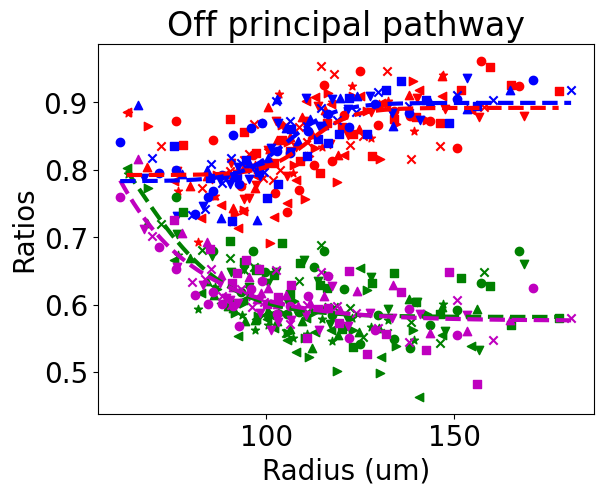

In [41]:
plt.scatter(c1xa, c1ya, c='r', marker='x')
plt.scatter(c2xa, c2ya, c='r', marker='s')
plt.scatter(c3xa, c3ya, c='r', marker='o')
plt.scatter(c4xa, c4ya, c='r', marker='v')
plt.scatter(c5xa, c5ya, c='r', marker='^')
plt.scatter(c6xa, c6ya, c='r', marker='<')
plt.scatter(c7xa, c7ya, c='r', marker='>')
plt.scatter(c8xa, c8ya, c='r', marker='*')

# Alpha Hypers (cyan)
plt.scatter(h1xa, h1ya, c='b', marker='x')
plt.scatter(h2xa, h2ya, c='b', marker='s')
plt.scatter(h3xa, h3ya, c='b', marker='o')
plt.scatter(h4xa, h4ya, c='b', marker='v')
plt.scatter(h5xa, h5ya, c='b', marker='^')

# Beta Controls (green)
plt.scatter(c1x, c1y, c='g', marker='x')
plt.scatter(c2x, c2y, c='g', marker='s')
plt.scatter(c3x, c3y, c='g', marker='o')
plt.scatter(c4x, c4y, c='g', marker='v')
plt.scatter(c5x, c5y, c='g', marker='^')
plt.scatter(c6x, c6y, c='g', marker='<')
plt.scatter(c7x, c7y, c='g', marker='>')
plt.scatter(c8x, c8y, c='g', marker='*')

# Beta Hypers (magenta)
plt.scatter(h1x, h1y, c='m', marker='x')
plt.scatter(h2x, h2y, c='m', marker='s')
plt.scatter(h3x, h3y, c='m', marker='o')
plt.scatter(h4x, h4y, c='m', marker='v')
plt.scatter(h5x, h5y, c='m', marker='^')

# Horizontal lines for averages
plt.plot(x_fit_control, y_fit_control, color='g', linestyle='--',linewidth=3.0)
plt.plot(x_fit_hyper, y_fit_hyper, color='m', linestyle='--',linewidth=3.0)
plt.plot(x_fit_controla, y_fit_controla, color='r', linestyle='--',linewidth=3.0)
plt.plot(x_fit_hypera, y_fit_hypera, color='b', linestyle='--',linewidth=3.0)

# === SIMPLIFIED LEGEND ===
plt.scatter([], [], c='r', label='Control Alpha')
plt.scatter([], [], c='b', label='Hyper Alpha')
plt.scatter([], [], c='g', label='Control Beta')
plt.scatter([], [], c='m', label='Hyper Beta')

plt.xlabel('Radius (um)',fontsize=20)
plt.ylabel('Ratios',fontsize=20)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.title('Off principal pathway',fontsize=24)
plt.show()

## Line of Best Fit LRR

In [88]:
# Bin Controls
y = 'Length/Radius'
x = 'Radius'
c1x,c1y = bintoPlot(control1,y,x)
c2x,c2y = bintoPlot(control2,y,x)
c3x,c3y = bintoPlot(control3,y,x)
c4x,c4y = bintoPlot(control4,y,x)
c5x,c5y = bintoPlot(control5,y,x)
c6x,c6y = bintoPlot(control6,y,x)
c7x,c7y = bintoPlot(control7,y,x)
c8x,c8y = bintoPlot(control8,y,x)
# Bin Hypertensives
h1x,h1y = bintoPlot(hyper1,y,x)
h2x,h2y = bintoPlot(hyper2,y,x)
h3x,h3y = bintoPlot(hyper3,y,x)
h4x,h4y = bintoPlot(hyper4,y,x)
h5x,h5y = bintoPlot(hyper5,y,x)

In [89]:
controly = np.concat((c1y,c2y,c3y,c4y,c5y,c6y,c7y,c8y),axis=0)
controlx = np.concat((c1x,c2x,c3x,c4x,c5x,c6x,c7x,c8x),axis=0)
hypery = np.concat((h1y,h2y,h3y,h4y,h5y),axis=0)
hyperx = np.concat((h1x,h2x,h3x,h4x,h5x),axis=0)

paramsc, _ = curve_fit(exponential, controlx, controly,p0=[10, 0.008])
paramsh, _ = curve_fit(exponential, hyperx, hypery,p0=[10, 0.008])
print(paramsc)
print(paramsh)
x_range = np.linspace(min(min(hyperx),min(controlx)),max(max(hyperx),max(controlx)), 1000)
c_fit = exponential(x_range, *paramsc)
h_fit = exponential(x_range, *paramsh)

[3.15254379e+01 1.39850150e-02]
[2.82485612e+01 1.49786714e-02]


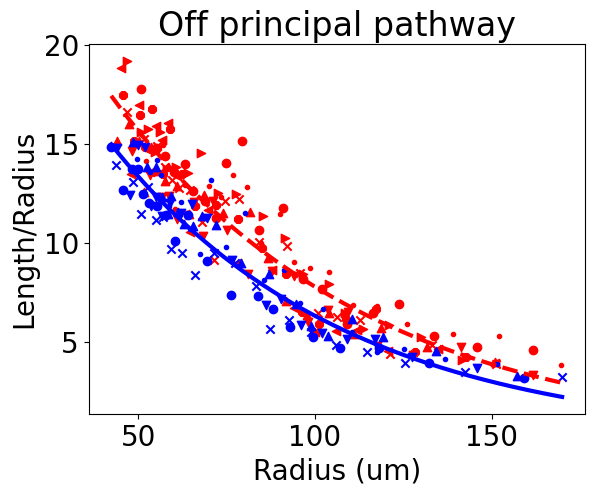

In [24]:
plt.scatter(c1x,c1y, c='r', marker='x', label='Control 1')
plt.scatter(c2x,c2y, c='r', marker='.', label='Control 2')
plt.scatter(c3x,c3y, c='r', marker='o', label='Control 3')
plt.scatter(c4x,c4y, c='r', marker='v', label='Control 4')
plt.scatter(c5x,c5y, c='r', marker='^', label='Control 5')
plt.scatter(c6x,c6y, c='r', marker='<', label='Control 6')
plt.scatter(c7x,c7y, c='r', marker='>', label='Control 7')
plt.scatter(c8x,c8y, c='r', marker='8', label='Control 8')
plt.scatter(h1x,h1y, c='b', marker='x', label='Hyper 1')
plt.scatter(h2x,h2y, c='b', marker='.', label='Hyper 2')
plt.scatter(h3x,h3y, c='b', marker='o', label='Hyper 3')
plt.scatter(h4x,h4y, c='b', marker='v', label='Hyper 4')
plt.scatter(h5x,h5y, c='b', marker='^', label='Hyper 5')
plt.plot(x_range, c_fit, color='red', linestyle='--', label='Control Fit',linewidth=3.0)
plt.plot(x_range, h_fit, color='b', linestyle='-', label='Hypertensive Fit',linewidth=3.0)
#plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.xlabel('Radius (um)',fontsize=20)
plt.ylabel(y,fontsize=20)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.title('Off principal pathway',fontsize=24)
plt.show()

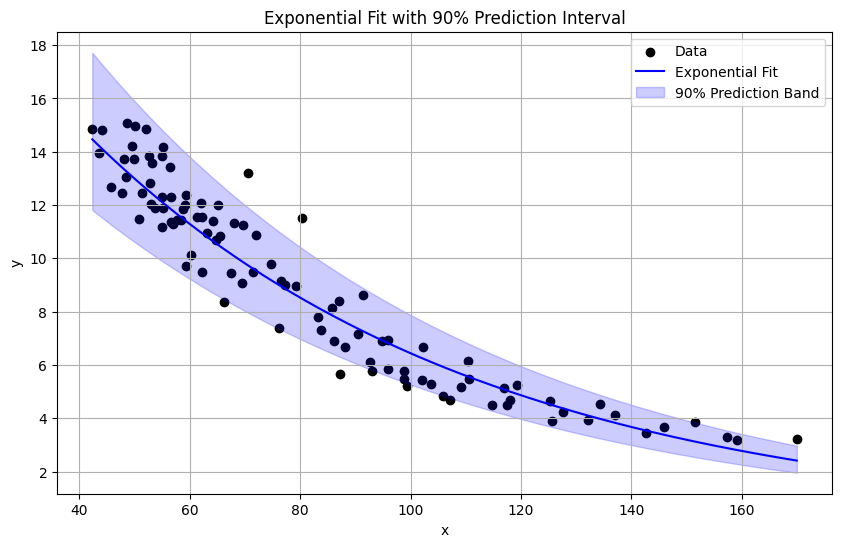

In [97]:
# Remove non-positive y values (since log(y) must be defined)
mask = hypery > 0
x = hyperx[mask]
y = hypery[mask]

# Linearize: ln(y) = ln(a) + b*x
log_y = np.log(y)

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_y)
log_y_pred = intercept + slope * x

# Residuals and standard error
n = len(x)
residuals = log_y - log_y_pred
s_err = np.sqrt(np.sum(residuals**2) / (n - 2))

# t critical value for 95% prediction interval
t_val = stats.t.ppf(0.95, df=n - 2)

# Generate smooth x values for prediction
x_fit = np.linspace(np.min(x), np.max(x), 200)
log_y_fit = intercept + slope * x_fit

# Compute standard error of the prediction (for prediction interval)
mean_x = np.mean(x)
sum_sq = np.sum((x - mean_x)**2)
SE_pred = s_err * np.sqrt(1 + 1/n + (x_fit - mean_x)**2 / sum_sq)

# Compute upper and lower bounds in log space
log_y_upper = log_y_fit + t_val * SE_pred
log_y_lower = log_y_fit - t_val * SE_pred

# Convert everything back to original scale
y_fit = np.exp(log_y_fit)
y_upper = np.exp(log_y_upper)
y_lower = np.exp(log_y_lower)

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Data', color='black')
plt.plot(x_fit, y_fit, label='Exponential Fit', color='blue')
plt.fill_between(x_fit, y_lower, y_upper, color='blue', alpha=0.2, label='90% Prediction Band')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Exponential Fit with 90% Prediction Interval')
plt.grid(True)
plt.show()

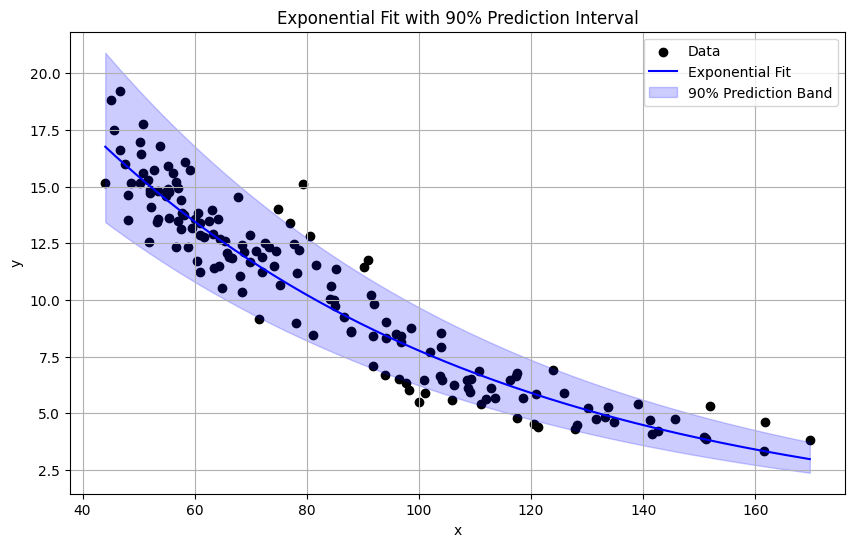

In [98]:
# Remove non-positive y values (since log(y) must be defined)
mask = controly > 0
x = controlx[mask]
y = controly[mask]

# Linearize: ln(y) = ln(a) + b*x
log_y = np.log(y)

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_y)
log_y_pred = intercept + slope * x

# Residuals and standard error
n = len(x)
residuals = log_y - log_y_pred
s_err = np.sqrt(np.sum(residuals**2) / (n - 2))

# t critical value for 95% prediction interval
t_val = stats.t.ppf(0.95, df=n - 2)

# Generate smooth x values for prediction
x_fit = np.linspace(np.min(x), np.max(x), 200)
log_y_fit = intercept + slope * x_fit

# Compute standard error of the prediction (for prediction interval)
mean_x = np.mean(x)
sum_sq = np.sum((x - mean_x)**2)
SE_pred = s_err * np.sqrt(1 + 1/n + (x_fit - mean_x)**2 / sum_sq)

# Compute upper and lower bounds in log space
log_y_upper = log_y_fit + t_val * SE_pred
log_y_lower = log_y_fit - t_val * SE_pred

# Convert everything back to original scale
y_fit = np.exp(log_y_fit)
y_upper = np.exp(log_y_upper)
y_lower = np.exp(log_y_lower)

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Data', color='black')
plt.plot(x_fit, y_fit, label='Exponential Fit', color='blue')
plt.fill_between(x_fit, y_lower, y_upper, color='blue', alpha=0.2, label='90% Prediction Band')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Exponential Fit with 90% Prediction Interval')
plt.grid(True)
plt.show()

## Line of Best Fit LRR

In [79]:
# Bin Controls
y = 'Length/Radius'
x = 'Radius'
c1x,c1y = bintoPlotS(control1,y,x)
c2x,c2y = bintoPlotS(control2,y,x)
c3x,c3y = bintoPlotS(control3,y,x)
c4x,c4y = bintoPlotS(control4,y,x)
c5x,c5y = bintoPlotS(control5,y,x)
c6x,c6y = bintoPlotS(control6,y,x)
c7x,c7y = bintoPlotS(control7,y,x)
c8x,c8y = bintoPlotS(control8,y,x)
# Bin Hypertensives
h1x,h1y = bintoPlotS(hyper1,y,x)
h2x,h2y = bintoPlotS(hyper2,y,x)
h3x,h3y = bintoPlotS(hyper3,y,x)
h4x,h4y = bintoPlotS(hyper4,y,x)
h5x,h5y = bintoPlotS(hyper5,y,x)

In [80]:
controly = np.concat((c1y,c2y,c3y,c4y,c5y,c6y,c7y,c8y),axis=0)
controlx = np.concat((c1x,c2x,c3x,c4x,c5x,c6x,c7x,c8x),axis=0)
hypery = np.concat((h1y,h2y,h3y,h4y,h5y),axis=0)
hyperx = np.concat((h1x,h2x,h3x,h4x,h5x),axis=0)

paramsc, _ = curve_fit(exponential, controlx, controly,p0=[10, 0.008])
paramsh, _ = curve_fit(exponential, hyperx, hypery,p0=[10, 0.008])
print(paramsc)
print(paramsh)
x_range = np.linspace(min(min(hyperx),min(controlx)),max(max(hyperx),max(controlx)), 1000)
c_fit = exponential(x_range, *paramsc)
h_fit = exponential(x_range, *paramsh)

[2.89025405e+01 1.24891287e-02]
[2.78876211e+01 1.46367762e-02]


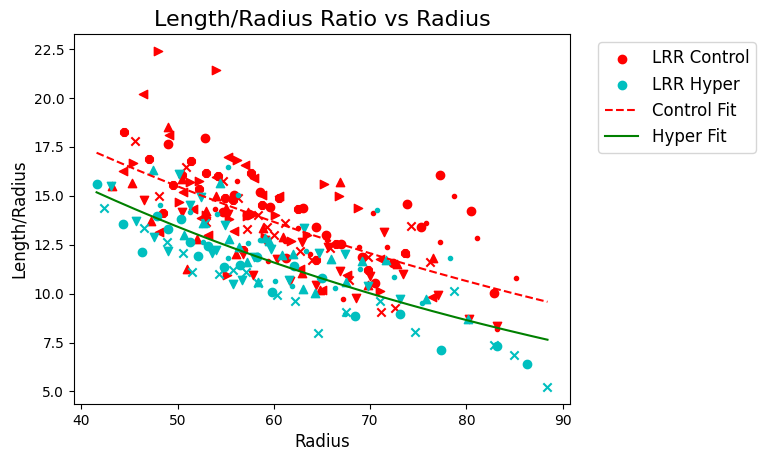

In [84]:
# Plot all control points in red with various markers
plt.scatter(c1x, c1y, c='r', marker='x')
plt.scatter(c2x, c2y, c='r', marker='.')
plt.scatter(c3x, c3y, c='r', marker='o')
plt.scatter(c4x, c4y, c='r', marker='v')
plt.scatter(c5x, c5y, c='r', marker='^')
plt.scatter(c6x, c6y, c='r', marker='<')
plt.scatter(c7x, c7y, c='r', marker='>')
plt.scatter(c8x, c8y, c='r', marker='8')

# Plot all hypertensive points in cyan with various markers
plt.scatter(h1x, h1y, c='c', marker='x')
plt.scatter(h2x, h2y, c='c', marker='.')
plt.scatter(h3x, h3y, c='c', marker='o')
plt.scatter(h4x, h4y, c='c', marker='v')
plt.scatter(h5x, h5y, c='c', marker='^')

# Add one representative scatter for legend only
plt.scatter([], [], c='r', label='LRR Control')
plt.scatter([], [], c='c', label='LRR Hyper')

# Add fit lines
plt.plot(x_range, c_fit, color='red', linestyle='--', label='Control Fit')
plt.plot(x_range, h_fit, color='green', linestyle='-', label='Hyper Fit')

# Legend
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', fontsize=12)

# Labels and title
plt.xlabel(x, fontsize=12)
plt.ylabel(y, fontsize=12)
plt.title('Length/Radius Ratio vs Radius',fontsize=16)  # Fill in if needed
plt.show()

# By Depth Comparison

In [39]:
def totalVolume(data):
    #v = data.groupby('Depth')['Volume'].sum()/(1000**3)
    a = data.groupby('Depth')['Radius'].mean()
    d = data.groupby('Depth')['Depth'].count()
    p = np.arange(0, len(d))
    return a, d, p

In [40]:
# Extract controls
c1v, c1d, c1p = totalVolume(control1)
c2v, c2d, c2p = totalVolume(control2)
c3v, c3d, c3p = totalVolume(control3)
c4v, c4d, c4p = totalVolume(control4)
c5v, c5d, c5p = totalVolume(control5)
c6v, c6d, c6p = totalVolume(control6)
c7v, c7d, c7p = totalVolume(control7)
c8v, c8d, c8p = totalVolume(control8)

In [41]:
h1v,h1d,h1p = totalVolume(hyper1)
h2v,h2d,h2p = totalVolume(hyper2)
h3v,h3d,h3p = totalVolume(hyper3)
h4v,h4d,h4p = totalVolume(hyper4)
h5v,h5d,h5p = totalVolume(hyper5)

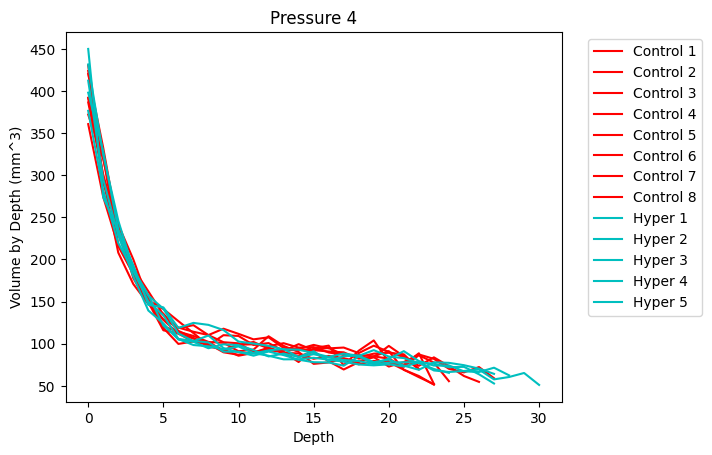

In [42]:
plt.plot(c1p,c1v,label='Control 1',color='r')
plt.plot(c2p,c2v,label='Control 2',color='r')
plt.plot(c3p,c3v,label='Control 3',color='r')
plt.plot(c4p,c4v,label='Control 4',color='r')
plt.plot(c5p,c5v,label='Control 5',color='r')
plt.plot(c6p,c6v,label='Control 6',color='r')
plt.plot(c7p,c7v,label='Control 7',color='r')
plt.plot(c8p,c8v,label='Control 8',color='r')
plt.plot(h1p,h1v,label='Hyper 1',color='c')
plt.plot(h2p,h2v,label='Hyper 2',color='c')
plt.plot(h3p,h3v,label='Hyper 3',color='c')
plt.plot(h4p,h4v,label='Hyper 4',color='c')
plt.plot(h5p,h5v,label='Hyper 5',color='c')
plt.ylabel('Volume by Depth (mm^3)')
plt.xlabel('Depth')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.title('Pressure 4')
plt.show()

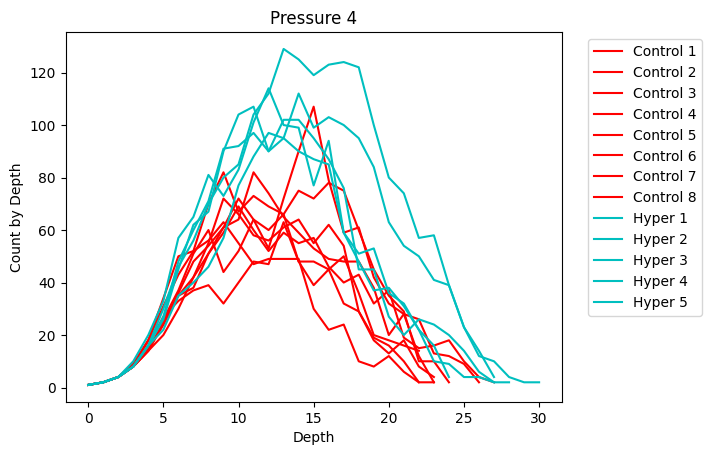

In [43]:
plt.plot(c1p,c1d,label='Control 1',color='r')
plt.plot(c2p,c2d,label='Control 2',color='r')
plt.plot(c3p,c3d,label='Control 3',color='r')
plt.plot(c4p,c4d,label='Control 4',color='r')
plt.plot(c5p,c5d,label='Control 5',color='r')
plt.plot(c6p,c6d,label='Control 6',color='r')
plt.plot(c7p,c7d,label='Control 7',color='r')
plt.plot(c8p,c8d,label='Control 8',color='r')
plt.plot(h1p,h1d,label='Hyper 1',color='c')
plt.plot(h2p,h2d,label='Hyper 2',color='c')
plt.plot(h3p,h3d,label='Hyper 3',color='c')
plt.plot(h4p,h4d,label='Hyper 4',color='c')
plt.plot(h5p,h5d,label='Hyper 5',color='c')
plt.ylabel('Count by Depth')
plt.xlabel('Depth')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.title('Pressure 4')
plt.show()

# Standardized by Volume

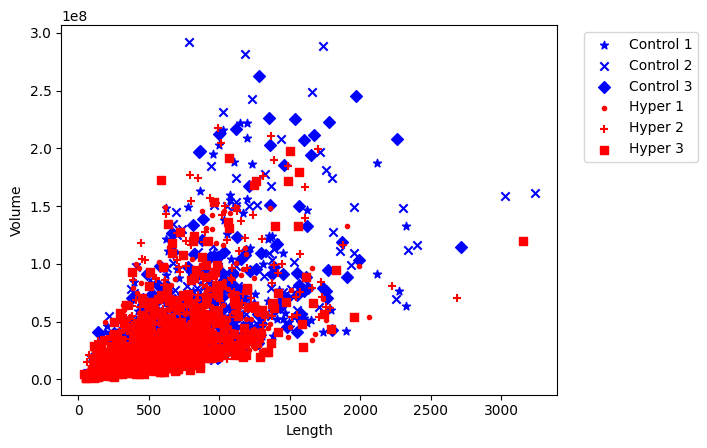

In [27]:
def volumeStandardizer(data):
    mean = data['Volume'].mean()
    std = data['Volume'].std()
    volumeFilter = data[(data['Volume'] >= mean - 2 * std) & 
                            (data['Volume'] <= mean + 2 * std)]
    internalVol = volumeFilter.dropna(subset='DV1R')
    return internalVol

y = 'Volume'
x = 'Length'
control1vs = volumeStandardizer(control1)
c1x = control1vs[x]
c1y = control1vs[y]
control2vs = volumeStandardizer(control2)
c2x = control2vs[x]
c2y = control2vs[y]
control3vs = volumeStandardizer(control3)
c3x = control3vs[x]
c3y = control3vs[y]
hyper1vs = volumeStandardizer(hyper1)
h1x = hyper1vs[x]
h1y = hyper1vs[y]
hyper2vs = volumeStandardizer(hyper2)
h2x = hyper2vs[x]
h2y = hyper2vs[y]
hyper3vs = volumeStandardizer(hyper3)
h3x = hyper3vs[x]
h3y = hyper3vs[y]

plt.scatter(c1x,c1y,c='b', marker='*',label='Control 1')
plt.scatter(c2x,c2y,c='b', marker='x',label='Control 2')
plt.scatter(c3x,c3y,c='b', marker='D',label='Control 3')
plt.scatter(h1x,h1y,c='r',marker='.',label='Hyper 1')
plt.scatter(h2x,h2y,c='r',marker='+',label='Hyper 2')
plt.scatter(h3x,h3y,c='r',marker=',',label='Hyper 3')
plt.ylabel(y)
plt.xlabel(x)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.show()